In [1]:
!set PYTHONPATH=D:\SharedLinux_D\CPSC_597\OCR_Math_Expressions\models\research;D:\SharedLinux_D\CPSC_597\OCR_Math_Expressions\models\research\slim

In [2]:
# call this before import maptlotlib ad after too
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import os
# import six.moves.urllib as urllib
import sys
# import tarfile
import tensorflow as tf
import zipfile
import cv2
import time
# from distutils.version import StrictVersion
# from collections import defaultdict
# from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import glob
import pandas as pd
import keras
from keras.models import load_model
from keras import backend as K
import xml.etree.ElementTree as ET
K.set_image_data_format('channels_first')
%matplotlib inline

Using TensorFlow backend.


In [3]:
# turn off tensorflow INFO (Debugging info)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [4]:
OD_PATH = 'models/research/object_detection/'

# append object_detection dir
sys.path.append(OD_PATH+"..")
from object_detection.utils import ops as utils_ops
# od imports
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

### Helpers

In [5]:
# Object Detection Helpers
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
              'num_detections', 'detection_boxes', 'detection_scores',
              'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
              'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [6]:
# Character Prediction Helpers
def one_hot_encode_to_char(arr, threshold=0.5, get_max=True):
    result = []
    val = 0
    for i in range(len(arr)):
        if arr[i] >= threshold:
            result.append((val, arr[i]))
        val +=1
    _max = []
    high = 0
    if get_max:
        for i in result:
            if i[1] > high:
                _max = [i[0]]
                high = i[1]
        return _max
    else:
        return [i[0] for i in result]


def one_hot_encode_to_char_list(arr, threshold=0.5, get_max=True):
    result = []
    for i in range(len(arr)):
        if arr[i] >= threshold:
            result.append((i, arr[i]))
    _max = []
    high = 0
    result = sorted(result, key=lambda x: x[1], reverse=True)
    if get_max:
        return result[-1]
    return result

In [7]:
# Object Detection Metrics Helpers

# read xml file
def read_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    all_boxes = []
    for i in root.iter('object'):
        ymin, xmin, ymax, xmax = None, None, None, None
        for j in i.findall("bndbox"):
            ymin = int(j.find("ymin").text)
            xmin = int(j.find("xmin").text)
            ymax = int(j.find("ymax").text)
            xmax = int(j.find("xmax").text)
        # bbox = [xmin, xmax, ymin, ymax]
        bbox = {
            'x1':xmin,
            'x2':xmax,
            'y1':ymin,
            'y2':ymax
        }
        all_boxes.append(bbox)
    return all_boxes

# calculate iou
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

def calculate_map(map_data):
    """
    map_data: a list of tuples with each tuple containing (precision, recall)
    """
    md = sorted(map_data, key=lambda x:x[1])
    md = [(i, round(j, 1)) for i, j in md]
    ap_11_precs = {str(round(k*0.1, 1)):None for k in range(11)}

    for p_, r_ in md:
        if not ap_11_precs[str(r_)] or p_ > ap_11_precs[str(r_)]:
            ap_11_precs[str(r_)] =  p_
            
    ap_11_precs_list = list(ap_11_precs.values())
    ap_11_precs_list = [z if z != None else 0 for z in ap_11_precs_list]
    mean_ap = np.mean(ap_11_precs_list)
    return mean_ap


### Load Faster-RCNN model

In [8]:
# VARIABLES
MODEL_NAME = 'faster_rcnn_resnet50_inference_graph'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = OD_PATH +'faster_rcnn_resnet50_training/'+ MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = OD_PATH + "faster_rcnn_resnet50_training/data/object-detection.pbtxt"

In [9]:
# Load tf model
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

### Load Object Detection label

In [10]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

### Load images

In [11]:
PATH_TO_TEST_IMAGES_DIR = "datasets/object_detection/test/*.png"
TEST_IMAGE_PATHS = list(glob.glob(PATH_TO_TEST_IMAGES_DIR))
print("Test Image paths: ")
for i in TEST_IMAGE_PATHS:
    print(i)
    
# Change TEST/TRAIN Images to test here
image_paths = TEST_IMAGE_PATHS

Test Image paths: 
datasets/object_detection/test\exp0015.png
datasets/object_detection/test\exp0016.png
datasets/object_detection/test\exp0029.png
datasets/object_detection/test\exp0037.png
datasets/object_detection/test\exp0044.png
datasets/object_detection/test\exp0051.png
datasets/object_detection/test\exp9.png


### Load CNN/ANN Model

In [12]:
IMAGE_SIZE = (320, 320)
models_path = "trained_models/"

# CNN
#cnn = load_model(models_path+"hasyv2model31.h5")
#cnn = load_model(models_path+"hasyv2model51.h5")
cnn = load_model(models_path+"model3.h5")

# ANN
#ann = load_model(models_path+"ann1.h5")

### Load symbols

In [13]:
symbols = pd.read_csv("processed_data/symbols.csv").drop(["Unnamed: 0"], axis=1)
symbols.head()

,latex,old_symbol,new_id
0,A,31,0
1,B,32,1
2,C,33,2
3,D,34,3
4,E,35,4


### Object Detection

In [14]:
%matplotlib inline

-------------------------
Detecting Boxes for Image:  datasets/object_detection/test/exp0015.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.4345089  xmin:  0.8073622  ymax:  0.53822976  xmax  0.89340323
left:  258.3559036254883  right:  285.88903427124023  top:  139.04284477233887  bottom  172.23352432250977
Top left point: ( 258 ,  139 ) and Bottom right point: ( 285 ,  172 )
CNN/ANN Predictions:
Symbol_id: 24 , Latex: Y , Confidence Score: 49.16 %
Symbol_id: 60 , Latex: y , Confidence Score: 28.85 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 17.93 %
Symbol_id: 59 , Latex: x , Confidence Score: 3.49 %


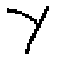

***************
Box: 
ymin:  0.45542693  xmin:  0.05807078  ymax:  0.5600235  xmax  0.18128173
left:  18.58264923095703  right:  58.01015377044678  top:  145.7366180419922  bottom  179.20751571655273
Top left point: ( 18 ,  145 ) and Bottom right point: ( 58 ,  179 )
CNN/ANN Predictions:
Symbol_id: 25 , Latex: Z , Confidence Score: 55.22 %
Symbol_id: 61 , Latex: z , Confidence Score: 41.54 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 2.86 %


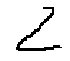

***************
Box: 
ymin:  0.4538977  xmin:  0.4022026  ymax:  0.5563907  xmax  0.5425219
left:  128.704833984375  right:  173.60700607299805  top:  145.2472686767578  bottom  178.04502487182617
Top left point: ( 128 ,  145 ) and Bottom right point: ( 173 ,  178 )
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 98.17 %
Symbol_id: 59 , Latex: x , Confidence Score: 1.77 %


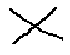

***************
Box: 
ymin:  0.44894138  xmin:  0.6135501  ymax:  0.5424399  xmax  0.71721095
left:  196.33604049682617  right:  229.50750350952148  top:  143.66124153137207  bottom  173.58076095581055
Top left point: ( 196 ,  143 ) and Bottom right point: ( 229 ,  173 )
CNN/ANN Predictions:
Symbol_id: 96 , Latex: \perp , Confidence Score: 61.56 %
Symbol_id: 84 , Latex: + , Confidence Score: 30.84 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 2.2 %
Symbol_id: 88 , Latex: \& , Confidence Score: 1.45 %
Symbol_id: 42 , Latex: f , Confidence Score: 1.31 %
Symbol_id: 7 , Latex: H , Confidence Score: 1.22 %


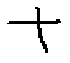

***************
Box: 
ymin:  0.46200114  xmin:  0.25871855  ymax:  0.57575047  xmax  0.35857248
left:  82.78993606567383  right:  114.74319458007812  top:  147.8403663635254  bottom  184.24015045166016
Top left point: ( 82 ,  147 ) and Bottom right point: ( 114 ,  184 )
CNN/ANN Predictions:
Symbol_id: 104 , Latex: = , Confidence Score: 66.53 %
Symbol_id: 83 , Latex: - , Confidence Score: 19.03 %
Symbol_id: 94 , Latex: \div , Confidence Score: 11.05 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 1.08 %


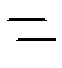

true {'x1': 14, 'x2': 60, 'y1': 142, 'y2': 179}
pred {'x1': 18.58264923095703, 'x2': 58.01015377044678, 'y1': 145.7366180419922, 'y2': 179.20751571655273}
IOU : 0.766872926932499
---------------
true {'x1': 130, 'x2': 178, 'y1': 142, 'y2': 177}
pred {'x1': 128.704833984375, 'x2': 173.60700607299805, 'y1': 145.2472686767578, 'y2': 178.04502487182617}
IOU : 0.7831466156235428
---------------
true {'x1': 195, 'x2': 230, 'y1': 139, 'y2': 175}
pred {'x1': 196.33604049682617, 'x2': 229.50750350952148, 'y1': 143.66124153137207, 'y2': 173.58076095581055}
IOU : 0.7876779618614126
---------------
true {'x1': 256, 'x2': 284, 'y1': 136, 'y2': 170}
pred {'x1': 258.3559036254883, 'x2': 285.88903427124023, 'y1': 139.04284477233887, 'y2': 172.23352432250977}
IOU : 0.7405660014947094
---------------
true {'x1': 79, 'x2': 121, 'y1': 141, 'y2': 179}
pred {'x1': 82.78993606567383, 'x2': 114.74319458007812, 'y1': 147.8403663635254, 'y2': 184.24015045166016}
IOU : 0.564607752689991
---------------
{'TP': 5,

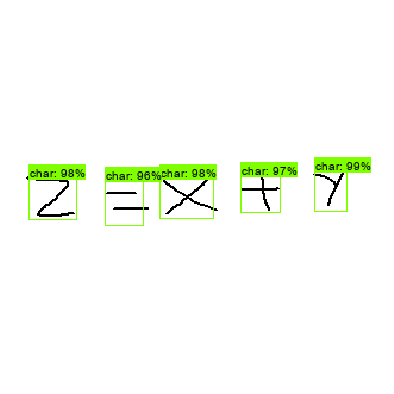

-------------------------
Detecting Boxes for Image:  datasets/object_detection/test/exp0016.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.4592886  xmin:  0.80772877  ymax:  0.58294106  xmax  0.8950295
left:  258.47320556640625  right:  286.4094352722168  top:  146.97235107421875  bottom  186.5411376953125
Top left point: ( 258 ,  146 ) and Bottom right point: ( 286 ,  186 )
CNN/ANN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 65.06 %
Symbol_id: 24 , Latex: Y , Confidence Score: 12.61 %
Symbol_id: 59 , Latex: x , Confidence Score: 6.84 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 3.63 %
Symbol_id: 61 , Latex: z , Confidence Score: 3.46 %
Symbol_id: 33 , Latex: 7 , Confidence Score: 2.49 %
Symbol_id: 25 , Latex: Z , Confidence Score: 1.46 %
Symbol_id: 92 , Latex: \times , Confidence Score: 1.29 %


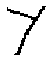

***************
Box: 
ymin:  0.4637743  xmin:  0.050667226  ymax:  0.58251876  xmax  0.17326547
left:  16.213512420654297  right:  55.44495105743408  top:  148.40777397155762  bottom  186.40600204467773
Top left point: ( 16 ,  148 ) and Bottom right point: ( 55 ,  186 )
CNN/ANN Predictions:
Symbol_id: 25 , Latex: Z , Confidence Score: 93.33 %
Symbol_id: 61 , Latex: z , Confidence Score: 6.22 %


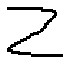

***************
Box: 
ymin:  0.4696555  xmin:  0.21608396  ymax:  0.5887567  xmax  0.3260028
left:  69.14686679840088  right:  104.32089805603027  top:  150.28976440429688  bottom  188.40213775634766
Top left point: ( 69 ,  150 ) and Bottom right point: ( 104 ,  188 )
CNN/ANN Predictions:
Symbol_id: 83 , Latex: - , Confidence Score: 48.59 %
Symbol_id: 104 , Latex: = , Confidence Score: 22.36 %
Symbol_id: 94 , Latex: \div , Confidence Score: 14.23 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 7.81 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 4.4 %


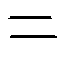

***************
Box: 
ymin:  0.46143577  xmin:  0.58968365  ymax:  0.5513729  xmax  0.7266938
left:  188.69876861572266  right:  232.54201889038086  top:  147.65944480895996  bottom  176.43932342529297
Top left point: ( 188 ,  147 ) and Bottom right point: ( 232 ,  176 )
CNN/ANN Predictions:
Symbol_id: 96 , Latex: \perp , Confidence Score: 31.84 %
Symbol_id: 19 , Latex: T , Confidence Score: 22.73 %
Symbol_id: 84 , Latex: + , Confidence Score: 16.82 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 16.27 %
Symbol_id: 94 , Latex: \div , Confidence Score: 3.13 %
Symbol_id: 5 , Latex: F , Confidence Score: 2.52 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 1.46 %
Symbol_id: 89 , Latex: \# , Confidence Score: 1.32 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 1.02 %


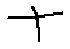

***************
Box: 
ymin:  0.46859694  xmin:  0.39668804  ymax:  0.5685658  xmax  0.5022097
left:  126.9401741027832  right:  160.70711135864258  top:  149.95101928710938  bottom  181.9410514831543
Top left point: ( 126 ,  149 ) and Bottom right point: ( 160 ,  181 )
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 99.85 %


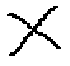

true {'x1': 14, 'x2': 62, 'y1': 148, 'y2': 186}
pred {'x1': 16.213512420654297, 'x2': 55.44495105743408, 'y1': 148.40777397155762, 'y2': 186.40600204467773}
IOU : 0.8015515135072201
---------------
true {'x1': 126, 'x2': 161, 'y1': 148, 'y2': 182}
pred {'x1': 126.9401741027832, 'x2': 160.70711135864258, 'y1': 149.95101928710938, 'y2': 181.9410514831543}
IOU : 0.9077356386359413
---------------
true {'x1': 188, 'x2': 235, 'y1': 144, 'y2': 178}
pred {'x1': 188.69876861572266, 'x2': 232.54201889038086, 'y1': 147.65944480895996, 'y2': 176.43932342529297}
IOU : 0.7896141558511715
---------------
true {'x1': 251, 'x2': 288, 'y1': 144, 'y2': 184}
pred {'x1': 258.47320556640625, 'x2': 286.4094352722168, 'y1': 146.97235107421875, 'y2': 186.5411376953125}
IOU : 0.6669372690962341
---------------
true {'x1': 70, 'x2': 103, 'y1': 148, 'y2': 184}
pred {'x1': 69.14686679840088, 'x2': 104.32089805603027, 'y1': 150.28976440429688, 'y2': 188.40213775634766}
IOU : 0.785548866803322
---------------
{'TP'

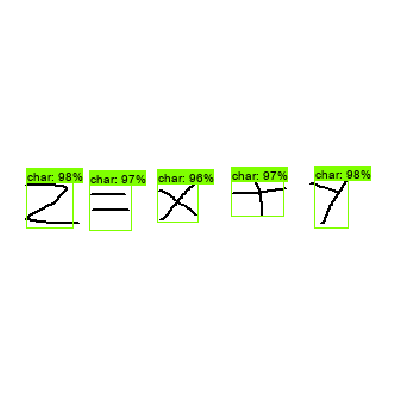

-------------------------
Detecting Boxes for Image:  datasets/object_detection/test/exp0029.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.3514517  xmin:  0.8673648  ymax:  0.4682133  xmax  0.9261733
left:  277.5567436218262  right:  296.3754653930664  top:  112.46454238891602  bottom  149.8282527923584
Top left point: ( 277 ,  112 ) and Bottom right point: ( 296 ,  149 )
CNN/ANN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 35.31 %
Symbol_id: 24 , Latex: Y , Confidence Score: 25.37 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 15.64 %
Symbol_id: 79 , Latex: > , Confidence Score: 10.26 %
Symbol_id: 87 , Latex: \} , Confidence Score: 4.51 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 3.73 %
Symbol_id: 72 , Latex: \rho , Confidence Score: 1.22 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.14 %


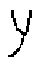

***************
Box: 
ymin:  0.35550758  xmin:  0.06011786  ymax:  0.46436378  xmax  0.17154773
left:  19.237715005874634  right:  54.89527225494385  top:  113.76242637634277  bottom  148.59641075134277
Top left point: ( 19 ,  113 ) and Bottom right point: ( 54 ,  148 )
CNN/ANN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 74.89 %
Symbol_id: 25 , Latex: Z , Confidence Score: 24.68 %


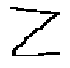

***************
Box: 
ymin:  0.35373026  xmin:  0.48190448  ymax:  0.4501435  xmax  0.59067315
left:  154.2094326019287  right:  189.01540756225586  top:  113.19368362426758  bottom  144.0459156036377
Top left point: ( 154 ,  113 ) and Bottom right point: ( 189 ,  144 )
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 98.7 %


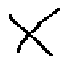

***************
Box: 
ymin:  0.35864046  xmin:  0.6707574  ymax:  0.44521356  xmax  0.77373755
left:  214.64237213134766  right:  247.59601593017578  top:  114.76494789123535  bottom  142.4683380126953
Top left point: ( 214 ,  114 ) and Bottom right point: ( 247 ,  142 )
CNN/ANN Predictions:
Symbol_id: 94 , Latex: \div , Confidence Score: 99.59 %


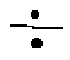

***************
Box: 
ymin:  0.35821077  xmin:  0.29763722  ymax:  0.45694256  xmax  0.3842879
left:  95.24391174316406  right:  122.97212600708008  top:  114.6274471282959  bottom  146.22161865234375
Top left point: ( 95 ,  114 ) and Bottom right point: ( 122 ,  146 )
CNN/ANN Predictions:
Symbol_id: 104 , Latex: = , Confidence Score: 51.92 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 35.39 %
Symbol_id: 105 , Latex: //( , Confidence Score: 4.52 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 3.81 %
Symbol_id: 94 , Latex: \div , Confidence Score: 1.13 %


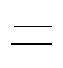

true {'x1': 154, 'x2': 189, 'y1': 113, 'y2': 147}
pred {'x1': 154.2094326019287, 'x2': 189.01540756225586, 'y1': 113.19368362426758, 'y2': 144.0459156036377}
IOU : 0.9016286218192016
---------------
true {'x1': 216, 'x2': 250, 'y1': 116, 'y2': 141}
pred {'x1': 214.64237213134766, 'x2': 247.59601593017578, 'y1': 114.76494789123535, 'y2': 142.4683380126953}
IOU : 0.811796788600002
---------------
true {'x1': 278, 'x2': 296, 'y1': 113, 'y2': 149}
pred {'x1': 277.5567436218262, 'x2': 296.3754653930664, 'y1': 112.46454238891602, 'y2': 149.8282527923584}
IOU : 0.9215839171910754
---------------
true {'x1': 19, 'x2': 55, 'y1': 113, 'y2': 149}
pred {'x1': 19.237715005874634, 'x2': 54.89527225494385, 'y1': 113.76242637634277, 'y2': 148.59641075134277}
IOU : 0.9584064753585996
---------------
true {'x1': 95, 'x2': 123, 'y1': 114, 'y2': 149}
pred {'x1': 95.24391174316406, 'x2': 122.97212600708008, 'y1': 114.6274471282959, 'y2': 146.22161865234375}
IOU : 0.8939285280711355
---------------
{'TP': 5

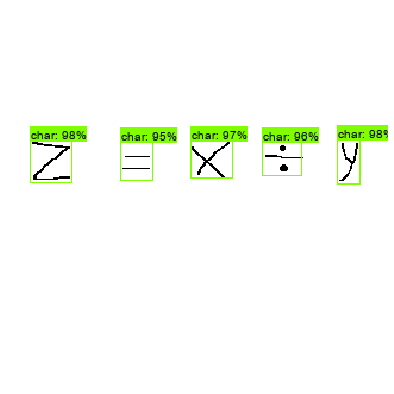

-------------------------
Detecting Boxes for Image:  datasets/object_detection/test/exp0037.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.3356567  xmin:  0.7600669  ymax:  0.41866755  xmax  0.86863214
left:  243.22141647338867  right:  277.96228408813477  top:  107.4101448059082  bottom  133.97361755371094
Top left point: ( 243 ,  107 ) and Bottom right point: ( 277 ,  133 )
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 99.89 %


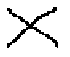

***************
Box: 
ymin:  0.3150346  xmin:  0.029498238  ymax:  0.4172163  xmax  0.13512087
left:  9.439436197280884  right:  43.238677978515625  top:  100.81107139587402  bottom  133.50921630859375
Top left point: ( 9 ,  100 ) and Bottom right point: ( 43 ,  133 )
CNN/ANN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 84.84 %
Symbol_id: 25 , Latex: Z , Confidence Score: 14.81 %


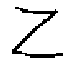

***************
Box: 
ymin:  0.32846949  xmin:  0.56763244  ymax:  0.43779954  xmax  0.6529292
left:  181.6423797607422  right:  208.93733978271484  top:  105.1102352142334  bottom  140.095853805542
Top left point: ( 181 ,  105 ) and Bottom right point: ( 208 ,  140 )
CNN/ANN Predictions:
Symbol_id: 90 , Latex: \% , Confidence Score: 100.0 %


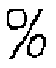

***************
Box: 
ymin:  0.3280091  xmin:  0.35380515  ymax:  0.44274312  xmax  0.40714517
left:  113.21764945983887  right:  130.28645515441895  top:  104.96291160583496  bottom  141.67779922485352
Top left point: ( 113 ,  104 ) and Bottom right point: ( 130 ,  141 )
CNN/ANN Predictions:
Symbol_id: 79 , Latex: > , Confidence Score: 29.53 %
Symbol_id: 24 , Latex: Y , Confidence Score: 23.12 %
Symbol_id: 60 , Latex: y , Confidence Score: 13.46 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 10.5 %
Symbol_id: 87 , Latex: \} , Confidence Score: 10.21 %
Symbol_id: 51 , Latex: o , Confidence Score: 4.64 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 3.47 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 1.07 %


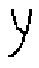

***************
Box: 
ymin:  0.3206036  xmin:  0.22811945  ymax:  0.4281101  xmax  0.30789933
left:  72.99822330474854  right:  98.52778434753418  top:  102.59315490722656  bottom  136.99522972106934
Top left point: ( 72 ,  102 ) and Bottom right point: ( 98 ,  136 )
CNN/ANN Predictions:
Symbol_id: 75 , Latex: \cdot , Confidence Score: 51.93 %
Symbol_id: 104 , Latex: = , Confidence Score: 19.46 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 9.74 %
Symbol_id: 105 , Latex: //( , Confidence Score: 7.88 %
Symbol_id: 83 , Latex: - , Confidence Score: 5.16 %
Symbol_id: 94 , Latex: \div , Confidence Score: 2.04 %


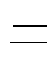

true {'x1': 11, 'x2': 45, 'y1': 99, 'y2': 134}
pred {'x1': 9.439436197280884, 'x2': 43.238677978515625, 'y1': 100.81107139587402, 'y2': 133.50921630859375}
IOU : 0.8494130300887489
---------------
true {'x1': 74, 'x2': 100, 'y1': 100, 'y2': 136}
pred {'x1': 72.99822330474854, 'x2': 98.52778434753418, 'y1': 102.59315490722656, 'y2': 136.99522972106934}
IOU : 0.8236177760017865
---------------
true {'x1': 114, 'x2': 131, 'y1': 105, 'y2': 142}
pred {'x1': 113.21764945983887, 'x2': 130.28645515441895, 'y1': 104.96291160583496, 'y2': 141.67779922485352}
IOU : 0.9073765312069878
---------------
true {'x1': 180, 'x2': 209, 'y1': 105, 'y2': 141}
pred {'x1': 181.6423797607422, 'x2': 208.93733978271484, 'y1': 105.1102352142334, 'y2': 140.095853805542}
IOU : 0.9146849241319458
---------------
true {'x1': 242, 'x2': 277, 'y1': 106, 'y2': 135}
pred {'x1': 243.22141647338867, 'x2': 277.96228408813477, 'y1': 107.4101448059082, 'y2': 133.97361755371094}
IOU : 0.8623002009706794
---------------
{'TP': 

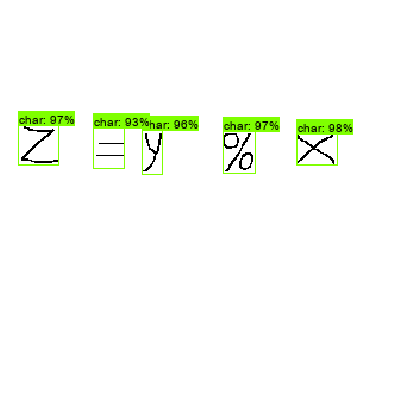

-------------------------
Detecting Boxes for Image:  datasets/object_detection/test/exp0044.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.47872972  xmin:  0.07530404  ymax:  0.60505265  xmax  0.15729415
left:  24.09729242324829  right:  50.334129333496094  top:  153.19351196289062  bottom  193.61684799194336
Top left point: ( 24 ,  153 ) and Bottom right point: ( 50 ,  193 )
CNN/ANN Predictions:
Symbol_id: 10 , Latex: K , Confidence Score: 85.86 %
Symbol_id: 47 , Latex: k , Confidence Score: 13.43 %


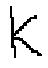

***************
Box: 
ymin:  0.48010692  xmin:  0.77554137  ymax:  0.593115  xmax  0.839472
left:  248.17323684692383  right:  268.6310386657715  top:  153.63421440124512  bottom  189.79679107666016
Top left point: ( 248 ,  153 ) and Bottom right point: ( 268 ,  189 )
CNN/ANN Predictions:
Symbol_id: 76 , Latex: \leq , Confidence Score: 97.62 %
Symbol_id: 90 , Latex: \% , Confidence Score: 1.34 %


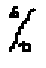

***************
Box: 
ymin:  0.50207037  xmin:  0.28142044  ymax:  0.596893  xmax  0.3593118
left:  90.05454063415527  right:  114.97977256774902  top:  160.66251754760742  bottom  191.00576400756836
Top left point: ( 90 ,  160 ) and Bottom right point: ( 114 ,  191 )
CNN/ANN Predictions:
Symbol_id: 37 , Latex: a , Confidence Score: 77.09 %
Symbol_id: 73 , Latex: \phi , Confidence Score: 11.46 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 5.6 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 4.2 %
Symbol_id: 88 , Latex: \& , Confidence Score: 1.23 %


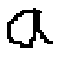

***************
Box: 
ymin:  0.48850852  xmin:  0.17880736  ymax:  0.5960128  xmax  0.25213957
left:  57.218356132507324  right:  80.68466186523438  top:  156.32272720336914  bottom  190.7240867614746
Top left point: ( 57 ,  156 ) and Bottom right point: ( 80 ,  190 )
CNN/ANN Predictions:
Symbol_id: 104 , Latex: = , Confidence Score: 84.31 %
Symbol_id: 94 , Latex: \div , Confidence Score: 9.8 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 2.88 %
Symbol_id: 68 , Latex: \epsilon , Confidence Score: 1.01 %


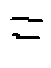

***************
Box: 
ymin:  0.44646993  xmin:  0.6725614  ymax:  0.58346885  xmax  0.74375033
left:  215.2196502685547  right:  238.00010681152344  top:  142.8703784942627  bottom  186.71003341674805
Top left point: ( 215 ,  142 ) and Bottom right point: ( 238 ,  186 )
CNN/ANN Predictions:
Symbol_id: 76 , Latex: \leq , Confidence Score: 77.67 %
Symbol_id: 45 , Latex: i , Confidence Score: 6.28 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 4.33 %
Symbol_id: 31 , Latex: 5 , Confidence Score: 2.24 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 1.41 %
Symbol_id: 88 , Latex: \& , Confidence Score: 1.23 %


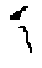

***************
Box: 
ymin:  0.48137876  xmin:  0.79131407  ymax:  0.58092433  xmax  0.8640731
left:  253.22050094604492  right:  276.50339126586914  top:  154.04120445251465  bottom  185.8957862854004
Top left point: ( 253 ,  154 ) and Bottom right point: ( 276 ,  185 )
CNN/ANN Predictions:
Symbol_id: 76 , Latex: \leq , Confidence Score: 72.43 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 25.2 %
Symbol_id: 88 , Latex: \& , Confidence Score: 1.64 %


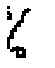

***************
Box: 
ymin:  0.48597765  xmin:  0.5168132  ymax:  0.6088921  xmax  0.6018768
left:  165.38022994995117  right:  192.6005744934082  top:  155.51284790039062  bottom  194.84546661376953
Top left point: ( 165 ,  155 ) and Bottom right point: ( 192 ,  194 )
CNN/ANN Predictions:
Symbol_id: 104 , Latex: = , Confidence Score: 48.68 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 19.74 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 12.04 %
Symbol_id: 64 , Latex: \delta , Confidence Score: 10.78 %
Symbol_id: 31 , Latex: 5 , Confidence Score: 5.74 %


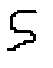

***************
Box: 
ymin:  0.49984837  xmin:  0.59992737  ymax:  0.5926346  xmax  0.69208926
left:  191.97675704956055  right:  221.46856307983398  top:  159.95147705078125  bottom  189.6430778503418
Top left point: ( 191 ,  159 ) and Bottom right point: ( 221 ,  189 )
CNN/ANN Predictions:
Symbol_id: 75 , Latex: \cdot , Confidence Score: 99.73 %


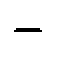

***************
Box: 
ymin:  0.5029639  xmin:  0.38822848  ymax:  0.592221  xmax  0.45642647
left:  124.23311233520508  right:  146.05647087097168  top:  160.94844818115234  bottom  189.51072692871094
Top left point: ( 124 ,  160 ) and Bottom right point: ( 146 ,  189 )
CNN/ANN Predictions:
Symbol_id: 7 , Latex: H , Confidence Score: 40.06 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 27.57 %
Symbol_id: 30 , Latex: 4 , Confidence Score: 11.33 %
Symbol_id: 84 , Latex: + , Confidence Score: 6.95 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 6.2 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 5.4 %


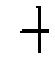

true {'x1': 24, 'x2': 51, 'y1': 142, 'y2': 196}
pred {'x1': 24.09729242324829, 'x2': 50.334129333496094, 'y1': 153.19351196289062, 'y2': 193.61684799194336}
IOU : 0.7274214504543214
---------------
true {'x1': 57, 'x2': 82, 'y1': 149, 'y2': 188}
pred {'x1': 57.218356132507324, 'x2': 80.68466186523438, 'y1': 156.32272720336914, 'y2': 190.7240867614746}
IOU : 0.7154983303455219
---------------
true {'x1': 88, 'x2': 120, 'y1': 160, 'y2': 189}
pred {'x1': 90.05454063415527, 'x2': 114.97977256774902, 'y1': 160.66251754760742, 'y2': 191.00576400756836}
IOU : 0.722211206223138
---------------
true {'x1': 130, 'x2': 153, 'y1': 158, 'y2': 187}
pred {'x1': 124.23311233520508, 'x2': 146.05647087097168, 'y1': 160.94844818115234, 'y2': 189.51072692871094}
IOU : 0.47968134869870993
---------------
true {'x1': 162, 'x2': 187, 'y1': 157, 'y2': 189}
pred {'x1': 165.38022994995117, 'x2': 192.6005744934082, 'y1': 155.51284790039062, 'y2': 194.84546661376953}
IOU : 0.5868883276213098
---------------
true 

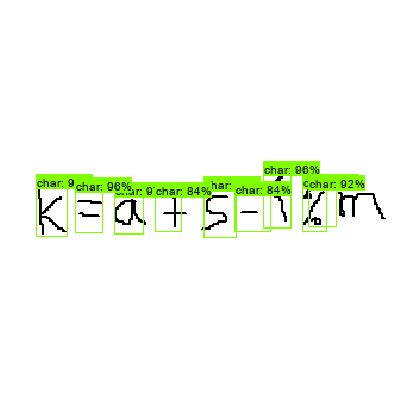

-------------------------
Detecting Boxes for Image:  datasets/object_detection/test/exp0051.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.23556586  xmin:  0.4702023  ymax:  0.37762108  xmax  0.58649516
left:  150.46473503112793  right:  187.67845153808594  top:  75.38107395172119  bottom  120.83874702453613
Top left point: ( 150 ,  75 ) and Bottom right point: ( 187 ,  120 )
CNN/ANN Predictions:
Symbol_id: 28 , Latex: 2 , Confidence Score: 98.8 %


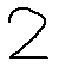

***************
Box: 
ymin:  0.26788518  xmin:  0.07105478  ymax:  0.375513  xmax  0.13366605
left:  22.737529277801514  right:  42.77313709259033  top:  85.72325706481934  bottom  120.16415596008301
Top left point: ( 22 ,  85 ) and Bottom right point: ( 42 ,  120 )
CNN/ANN Predictions:
Symbol_id: 30 , Latex: 4 , Confidence Score: 62.23 %
Symbol_id: 90 , Latex: \% , Confidence Score: 21.62 %
Symbol_id: 0 , Latex: A , Confidence Score: 5.13 %
Symbol_id: 6 , Latex: G , Confidence Score: 4.29 %
Symbol_id: 65 , Latex: \Delta , Confidence Score: 2.49 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 1.1 %
Symbol_id: 88 , Latex: \& , Confidence Score: 1.08 %


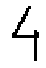

***************
Box: 
ymin:  0.2752652  xmin:  0.27113533  ymax:  0.37071678  xmax  0.3566868
left:  86.7633056640625  right:  114.1397762298584  top:  88.08485984802246  bottom  118.62936973571777
Top left point: ( 86 ,  88 ) and Bottom right point: ( 114 ,  118 )
CNN/ANN Predictions:
Symbol_id: 104 , Latex: = , Confidence Score: 98.89 %


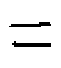

***************
Box: 
ymin:  0.17474644  xmin:  0.60771793  ymax:  0.27002805  xmax  0.6716077
left:  194.4697380065918  right:  214.91445541381836  top:  55.91886043548584  bottom  86.40897750854492
Top left point: ( 194 ,  55 ) and Bottom right point: ( 214 ,  86 )
CNN/ANN Predictions:
Symbol_id: 25 , Latex: Z , Confidence Score: 44.69 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 18.56 %
Symbol_id: 61 , Latex: z , Confidence Score: 14.52 %
Symbol_id: 59 , Latex: x , Confidence Score: 5.83 %
Symbol_id: 29 , Latex: 3 , Confidence Score: 4.65 %
Symbol_id: 33 , Latex: 7 , Confidence Score: 3.36 %
Symbol_id: 41 , Latex: e , Confidence Score: 2.39 %
Symbol_id: 69 , Latex: \lambda , Confidence Score: 1.6 %
Symbol_id: 88 , Latex: \& , Confidence Score: 1.3 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 1.29 %


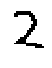

true {'x1': 25, 'x2': 48, 'y1': 84, 'y2': 126}
pred {'x1': 22.737529277801514, 'x2': 42.77313709259033, 'y1': 85.72325706481934, 'y2': 120.16415596008301}
IOU : 0.5863686136991311
---------------
true {'x1': 87, 'x2': 114, 'y1': 83, 'y2': 123}
pred {'x1': 86.7633056640625, 'x2': 114.1397762298584, 'y1': 88.08485984802246, 'y2': 118.62936973571777}
IOU : 0.755567970902199
---------------
true {'x1': 148, 'x2': 188, 'y1': 75, 'y2': 122}
pred {'x1': 150.46473503112793, 'x2': 187.67845153808594, 'y1': 75.38107395172119, 'y2': 120.83874702453613}
IOU : 0.8998132759562308
---------------
true {'x1': 196, 'x2': 215, 'y1': 57, 'y2': 81}
pred {'x1': 194.4697380065918, 'x2': 214.91445541381836, 'y1': 55.91886043548584, 'y2': 86.40897750854492}
IOU : 0.7258332538321918
---------------
{'TP': 4, 'FP': 0, 'TN': 0, 'FN': 0}
Precision:  1.0
Recall:  1.0


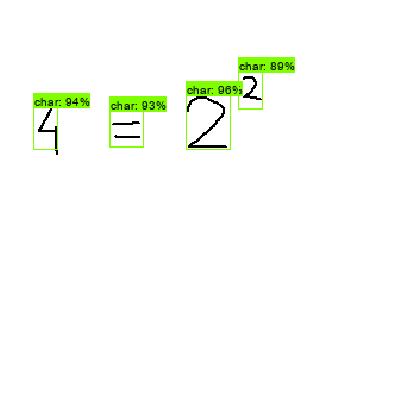

-------------------------
Detecting Boxes for Image:  datasets/object_detection/test/exp9.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.43371016  xmin:  0.021990944  ymax:  0.5422216  xmax  0.094772615
left:  7.037101984024048  right:  30.327236652374268  top:  138.78725051879883  bottom  173.51091384887695
Top left point: ( 7 ,  138 ) and Bottom right point: ( 30 ,  173 )
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 98.89 %
Symbol_id: 59 , Latex: x , Confidence Score: 1.09 %


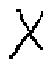

***************
Box: 
ymin:  0.42721078  xmin:  0.8552724  ymax:  0.5226557  xmax  0.95912963
left:  273.68717193603516  right:  306.92148208618164  top:  136.7074489593506  bottom  167.2498321533203
Top left point: ( 273 ,  136 ) and Bottom right point: ( 306 ,  167 )
CNN/ANN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 79.4 %
Symbol_id: 25 , Latex: Z , Confidence Score: 20.55 %


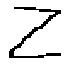

***************
Box: 
ymin:  0.4411399  xmin:  0.23745985  ymax:  0.52472574  xmax  0.29968497
left:  75.98715305328369  right:  95.89919090270996  top:  141.16477012634277  bottom  167.91223526000977
Top left point: ( 75 ,  141 ) and Bottom right point: ( 95 ,  167 )
CNN/ANN Predictions:
Symbol_id: 84 , Latex: + , Confidence Score: 99.95 %


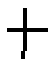

***************
Box: 
ymin:  0.42387992  xmin:  0.64103  ymax:  0.5200664  xmax  0.72569144
left:  205.1296043395996  right:  232.22126007080078  top:  135.64157485961914  bottom  166.4212417602539
Top left point: ( 205 ,  135 ) and Bottom right point: ( 232 ,  166 )
CNN/ANN Predictions:
Symbol_id: 104 , Latex: = , Confidence Score: 89.11 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 6.19 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 2.16 %


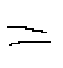

***************
Box: 
ymin:  0.42325908  xmin:  0.45082828  ymax:  0.5399701  xmax  0.49958307
left:  144.26505088806152  right:  159.86658096313477  top:  135.4429054260254  bottom  172.79043197631836
Top left point: ( 144 ,  135 ) and Bottom right point: ( 159 ,  172 )
CNN/ANN Predictions:
Symbol_id: 98 , Latex: \exists , Confidence Score: 64.25 %
Symbol_id: 60 , Latex: y , Confidence Score: 28.99 %
Symbol_id: 24 , Latex: Y , Confidence Score: 2.35 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.37 %


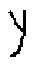

true {'x1': 8, 'x2': 32, 'y1': 139, 'y2': 175}
pred {'x1': 7.037101984024048, 'x2': 30.327236652374268, 'y1': 138.78725051879883, 'y2': 173.51091384887695}
IOU : 0.8540742224495325
---------------
true {'x1': 74, 'x2': 97, 'y1': 140, 'y2': 170}
pred {'x1': 75.98715305328369, 'x2': 95.89919090270996, 'y1': 141.16477012634277, 'y2': 167.91223526000977}
IOU : 0.7718790407504154
---------------
true {'x1': 143, 'x2': 160, 'y1': 137, 'y2': 174}
pred {'x1': 144.26505088806152, 'x2': 159.86658096313477, 'y1': 135.4429054260254, 'y2': 172.79043197631836}
IOU : 0.8547243755151909
---------------
true {'x1': 204, 'x2': 230, 'y1': 144, 'y2': 161}
pred {'x1': 205.1296043395996, 'x2': 232.22126007080078, 'y1': 135.64157485961914, 'y2': 166.4212417602539}
IOU : 0.49561471330734447
---------------
true {'x1': 272, 'x2': 309, 'y1': 133, 'y2': 169}
pred {'x1': 273.68717193603516, 'x2': 306.92148208618164, 'y1': 136.7074489593506, 'y2': 167.2498321533203}
IOU : 0.7620533301749336
---------------
{'TP': 

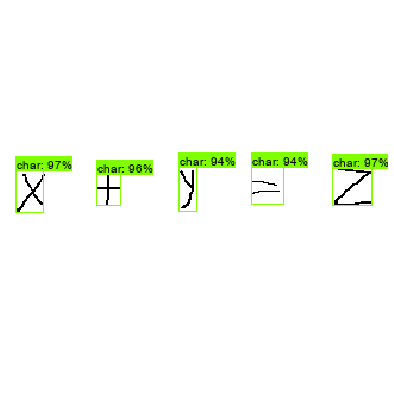

Mean Average Precision (mAP):  0.9535714285714285
Mean IOU:  0.7726180733231612


In [15]:
cnf = {'TP':0, 'FP':0, 'TN':0, 'FN':0}
map_data = []
iou_data = []

for image_path in TEST_IMAGE_PATHS:
    image_path = image_path.replace("\\", "/")
    im_name = image_path.split("/")[-1]
    image = Image.open(image_path)

    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = np.asarray(image)
    if len(image_np.shape) < 3:
    	image_np = cv2.cvtColor(image_np, cv2.COLOR_GRAY2RGB)
    else:
    	image_np = cv2.cvtColor(image_np, cv2.COLOR_RGBA2RGB)
    print('-'*25)
    print('Detecting Boxes for Image: ', image_path)
    print('Image shape: ', image_np.shape)
    
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)

    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)

    # Visualization of the results of a detection.
    """
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    """
    # cv2.imshow('scene', image_np)
    # plt.show()

    # crop image and display
    im_width, im_height = image.size
    cropped_images = []
    boxes_pred = []
    for i in range(output_dict['num_detections']):
        if output_dict['detection_scores'][i] > 0.8:
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.array([output_dict['detection_boxes'][i]]),
                np.array([output_dict['detection_classes'][i]]),
                np.array([output_dict['detection_scores'][i]]),
                category_index,
                instance_masks=output_dict.get('detection_masks'),
                use_normalized_coordinates=True,
                line_thickness=1)
            (ymin, xmin, ymax, xmax) = output_dict['detection_boxes'][i]
            (left, right, top, bottom) = (xmin * im_width,
                                          xmax * im_width,
                                          ymin * im_height,
                                          ymax * im_height)
            print('*'*15)
            print("Box: ")
            print("ymin: ", ymin," xmin: ", xmin, " ymax: ", ymax," xmax ", xmax)
            print("left: ", left," right: ", right," top: ", top," bottom ", bottom)
            print("Top left point: (",int(left),", ",int(top),") and Bottom right point: (",int(right),", ",int(bottom),")")
            
            cropped_image = image.crop((left, top, right, bottom))
            
            
            # boxes_pred.append([left, right, top, bottom])
            boxes_pred.append({
                'x1':left,
                'x2':right,
                'y1':top,
                'y2':bottom
            })
            
            # Predict label for cropped image with CNN
            c_im = np.asarray(cropped_image)
            c_im = cv2.cvtColor(c_im, cv2.COLOR_BGRA2RGBA)
            c_im = cv2.cvtColor(c_im, cv2.COLOR_RGBA2RGB)
            c_im = cv2.cvtColor(c_im, cv2.COLOR_RGBA2GRAY)
            c_im = cv2.resize(c_im, (32,32))
            c_im = c_im / 255.0
            # Symbol Prediction
            # CNN
            c_im = np.resize(c_im, (1, 1, 32, 32))
            res = cnn.predict(c_im)
            # ANN
            #c_im = c_im.flatten().reshape((1, 32*32))
            #print(c_im.shape)
            #res = ann.predict(c_im)
            #
            res = res.flatten()
            # lbl = one_hot_encode_to_char(res, threshold=0.1)
            # if type(lbl) == list: lbl = lbl[0]
            # print("Symbol is :", symbols.loc[symbols['new_id']==lbl])
            lbls = one_hot_encode_to_char_list(res, threshold=0.01, get_max = False)
            print("CNN/ANN Predictions:")
            for j in lbls:
                symbols_row = symbols[symbols['new_id'] == j[0]][['latex', 'old_symbol', 'new_id']]
                latex, old_symbol, new_id = symbols_row.iloc[0].to_list()
                print('Symbol_id:', new_id, ', Latex:', latex, ', Confidence Score:', round(j[1]*100, 2), '%')
            plt.figure(figsize=(1,1))
            plt.axis('off')
            temp_ = np.asarray(cropped_image)
            plt.imshow(temp_)
            plt.show()
            cropped_images.append(np.asarray(cropped_image))
            #cv2.imshow('model', np.asarray(cropped_image))
    # calculate IOU
    xml_path = image_path[:-3]+'xml'
    xml_path = xml_path.replace("\\", "/")
    boxes_true = read_annotation(xml_path)

    ious = []
    iou_threshold = 0.5
    # dont reset cnf
    cnf = {'TP':0, 'FP':0, 'TN':0, 'FN':0}
    for t in boxes_true:
        box_present = False
        for p in boxes_pred:
            if p['x1'] <= t['x1'] + 10 and p['x1'] >= t['x1'] - 10:
                print('true', t)
                print('pred', p)
                iou = get_iou(t, p)
                iou_data.append(iou)
                ious.append(iou)
                print('IOU :', iou)
                print('-----'*3)
                box_present = True
                if iou > iou_threshold:
                    cnf['TP'] += 1
                else:
                    cnf['FP'] += 1
                break
        if not box_present:
            cnf['FN'] += 1
    print(cnf)
    
    # prevent division by 0 error
    if cnf['TP'] + cnf['FP'] != 0 and cnf['TP'] + cnf['FN'] != 0:
        precision = cnf['TP'] / (cnf['TP'] + cnf['FP'])
        print('Precision: ', precision)
        recall = cnf['TP']/ (cnf['TP'] + cnf['FN'])
        print('Recall: ', recall)
        map_data.append((precision, recall))
    #

    plt.figure(figsize=(7,7))
    plt.axis('off')
    temp_ = cv2.resize(image_np, (int(im_width), int(im_height)))
    plt.imshow(temp_)
    plt.show()
    #cv2.imshow(im_name, cv2.resize(image_np, (int(im_width), int(im_height))))
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

# Calculate mAP (Mean Average Precision Score)
# mean_ap = calculate_map(map_data)
# print("Mean Average Precision (mAP): ", mean_ap)
print("Mean Average Precision (mAP): ", np.mean([i[0] for i in map_data]))

# Mean IOUs (not an ideal metric)
print("Mean IOU: ", np.mean(iou_data))